# TTT4185 Machine learning for Speech technology

## Voluntary computer assigment 1: Speech analysis

This assignment assumes that the student has knowledge about short-time spectral estimation, linear prediction modeling and cepstral analysis. You should also know the concept of fundamental frequencies and formants.

Useful commands include `matplotlib.pyplot.plot`.

### Problem 1

In this problem we will look at a speech signal and do simple spectral analysis on the signal.

(a) Download the speech file `stry.wav` from Blackboard and load the file using `scipy.io.wavefile.read`. The speech represents the latter half of the English word "tapestry". The phonetic transcription is /s/ /t/ /r/ /iy/.
- Plot the signal.
- What is characteristic about the sounds /s/, /t/, /r/ and /iy/?
  
     - /s/ the noisy disturbance
     - /t/ pressure/release
     - /iy/ actual voiced wave form
  
- Take a 40 millisecond subset of the vowel /iy/ and plot it.
- Find the fundamental frequency $F_0$ of the vowel.

    First approximation:
    $F_0 \approx \frac{6}{35ms} = 171 Hz$

    Second approximation:
    $F_0 \approx \frac{1}{7.34ms-1.74ms} = 178 Hz$

<IPython.core.display.Javascript object>


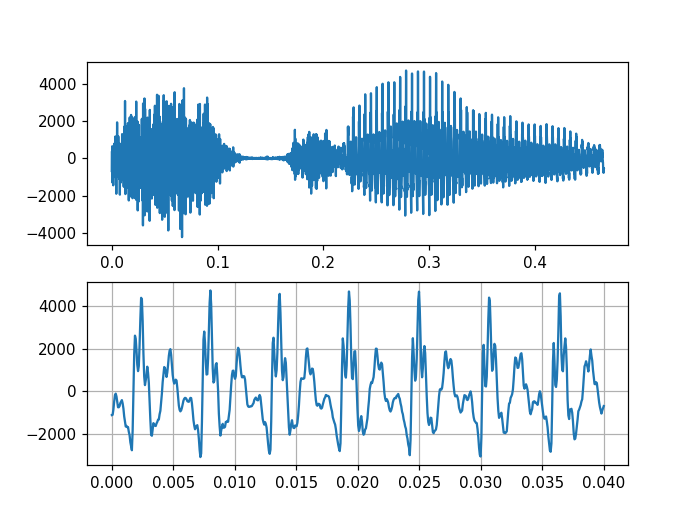

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile

fs, data = scipy.io.wavfile.read('stry.wav')

# Setup Plots
%matplotlib notebook
plt.ion()
fig, axs = plt.subplots(2,1)

# Plot stry.wav
n = np.linspace(start=0,stop=len(data)/fs,num=len(data))
axs[0].plot(n,data)

# Extract 40ms /iy/ and plot
n_zero = int(0.27*fs)
n_ms = int(0.04*fs)
iy_sample = data[n_zero:n_zero+n_ms]
n = np.linspace(start=0,stop=len(iy_sample)/fs,num=len(iy_sample))
axs[1].plot(n,iy_sample)
axs[1].grid()


(b) Spectral analysis
- Estimate the spectrum of the vowel using an FFT of length 1024. Plot the log-spectrum as a function of frequency
- Multiply the signal by a Hamming window and repeat the last operation.
- Explain the difference between the two spectra.
    
    The rectangular window introduces high frequency content, due to the "sharp" edges. It will transform into a sinc in the frequency-domain and add aditional ripple. Using a window in time-domain is an approximation to get a rectangular window in frequency domain.

    
- Estimate the fundamental frequency $F_0$ using the spectrum, and compare the result to what you got in 1a)

    $F_0 \approx 176Hz$
    

- Roughly estimate the two first formant frequencies.
    
    $F1 \approx 410Hz$
    
    $F2 \approx 1.9kHz$
    

Useful Python functions: `numpy.fft.fft`, `numpy.abs`, `scipy.signal.hamming`.

<IPython.core.display.Javascript object>


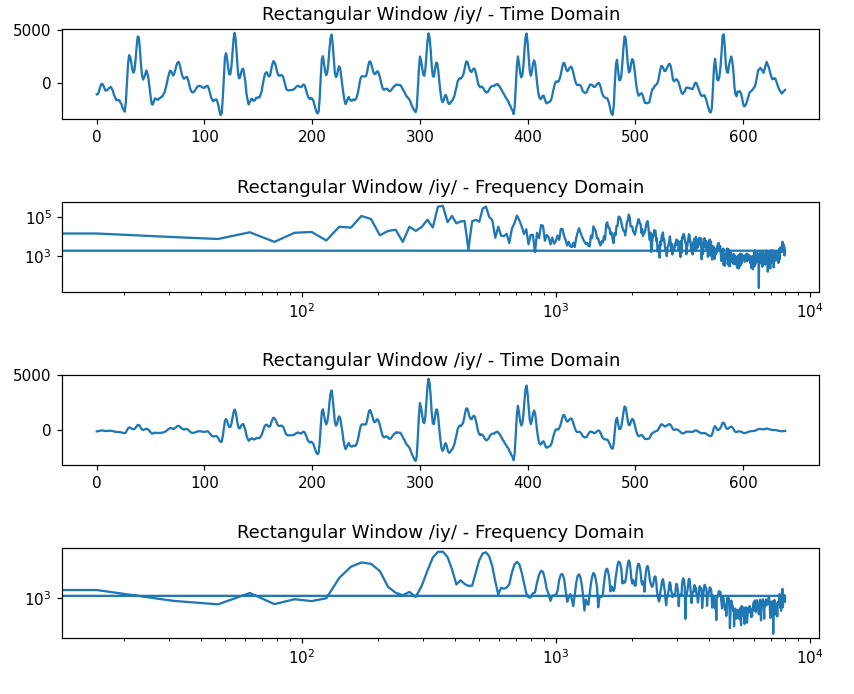

In [42]:
import scipy.signal

# Setup Plots
fig, axs = plt.subplots(4,1)
fig.tight_layout(h_pad=2)

# Setup global variables
fft_n = 1024

# Plot with rectangular window
iy_fft = np.fft.fft(iy_sample,n=fft_n)
iy_fft_freq = np.fft.fftfreq(n=fft_n,d=1/fs)
axs[0].set_title("Rectangular Window /iy/ - Time Domain")
axs[0].plot(iy_sample)
axs[1].set_title("Rectangular Window /iy/ - Frequency Domain")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].plot(iy_fft_freq,np.abs(iy_fft))

# Plot with hamming window
hamming = scipy.signal.hamming(M=len(iy_sample))
iy_hamming = iy_sample*hamming
iy_fft_hamming = np.fft.fft(iy_hamming,n=fft_n)
iy_fft_hamming_freq = np.fft.fftfreq(n=fft_n,d=1/fs)
axs[2].set_title("Rectangular Window /iy/ - Time Domain")
axs[2].plot(iy_hamming)
axs[3].set_title("Rectangular Window /iy/ - Frequency Domain")
axs[3].set_xscale("log")
axs[3].set_yscale("log")
axs[3].plot(iy_fft_hamming_freq,np.abs(iy_fft_hamming))

(c) AR modeling
- Compute the coefficients of an AR model (linear prediction coefficients) with order 4, 8, 16 and 50, based on the vowel.
- Estimate the spectrum for each of the model orders. Plot the log-spectrum as a function of frequency.
- Compare your results with the spectrum from 1b). Which model order yields the "best" spectral envelope? What happens if the model order is too high or too low?

    The model with order 16 seems to yield a good approximate to the spectrum from 1b).
    Either not modelling the formants "accurately" (= order too low) or starting to include additional features like harmonics of the glottal pulse in the model (= order too high).
    

- Why is it impossible to estimate the fundamental frequency based on the LP model?

    The LP model only models the formants which are usually a multitude of the fundamental frequency if related at all. To estimate the fundamental frequency we could possibly use the residue.
    

Useful Python functions: `pysptk.sptk.lpc`, `scipy.signal.freqz`.

<IPython.core.display.Javascript object>


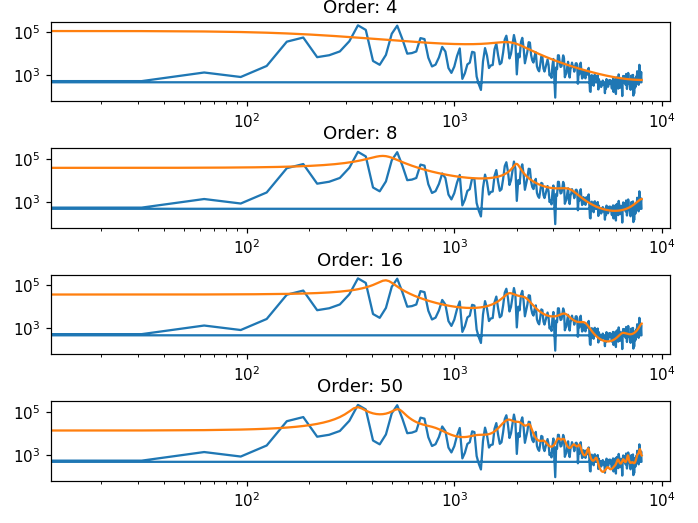

In [128]:
import pysptk


orders = [4,8,16,50]
models = []
ws = []
hs = []

fig, axs = plt.subplots(len(orders),1)
fig.tight_layout(h_pad=1)

iy_fft_hamming_half = np.fft.fft(iy_hamming,n=512)
iy_fft_hamming_freq_half = np.fft.fftfreq(n=512,d=1/fs)

for index, order in enumerate(orders):
    model = pysptk.sptk.lpc(windowed=iy_hamming,order=order)
    models.append(model)
    w, h = scipy.signal.freqz(model[0],np.concatenate(([1],model[1:])),fs=fs)
    ws.append(w)
    hs.append(h)
    axs[index].set_title(f"Order: {order}")
    axs[index].plot(iy_fft_hamming_freq_half,np.abs(iy_fft_hamming_half))
    axs[index].plot(w,np.abs(h))
    axs[index].set_xscale("log")
    axs[index].set_yscale("log")


(d) Use `scipy.signal.spectrogram` to create a spectrogram of the entire speech signal. Try to generate both wide- and narrow-band spectrograms by adjutinf the window lengths and overlaps. Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

    - /s/ "noise spectrum" of fricative
    - /iy/ formants

<IPython.core.display.Javascript object>


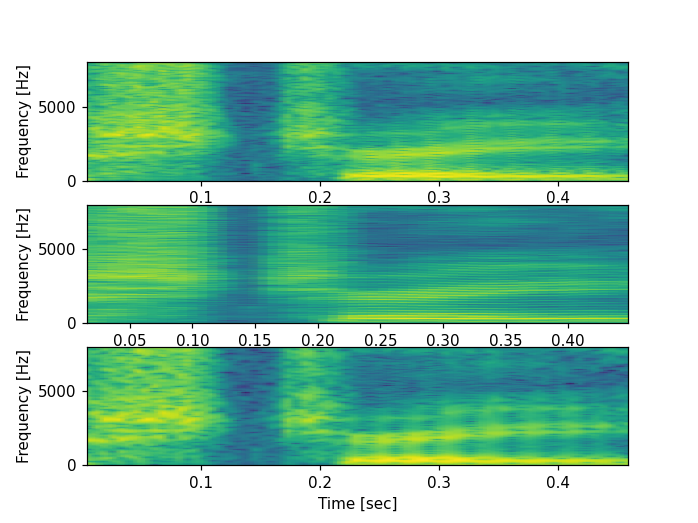

Text(0.5, 0, 'Time [sec]')

In [36]:
fig, axs = plt.subplots(3,1)

f, t, sxx = scipy.signal.spectrogram(
    x=data,
    fs=fs,
    nfft=fft_n,
    nperseg=128,
    noverlap=16,
    scaling='spectrum',
)
axs[0].pcolormesh(t, f, np.log(sxx), shading='gouraud')
axs[0].set_ylabel('Frequency [Hz]')
axs[0].set_xlabel('Time [sec]')

f, t, sxx = scipy.signal.spectrogram(
    x=data,
    fs=fs,
    nfft=fft_n,
    nperseg=512,
    noverlap=256,
    scaling='spectrum',
)
axs[1].pcolormesh(t, f, np.log(sxx), shading='gouraud')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')

f, t, sxx = scipy.signal.spectrogram(
    x=data,
    fs=fs,
    nfft=fft_n,
    nperseg=128,
    noverlap=16,
    scaling='spectrum',
    window=('hamming'),
)
axs[2].pcolormesh(t, f, np.log(sxx), shading='gouraud')
axs[2].set_ylabel('Frequency [Hz]')
axs[2].set_xlabel('Time [sec]')

### Problem 2
In this problem we look at the cepstrum and deconvolution

(a) Compute and plot the real cepstrum of the vowel from problem 1a).

<IPython.core.display.Javascript object>


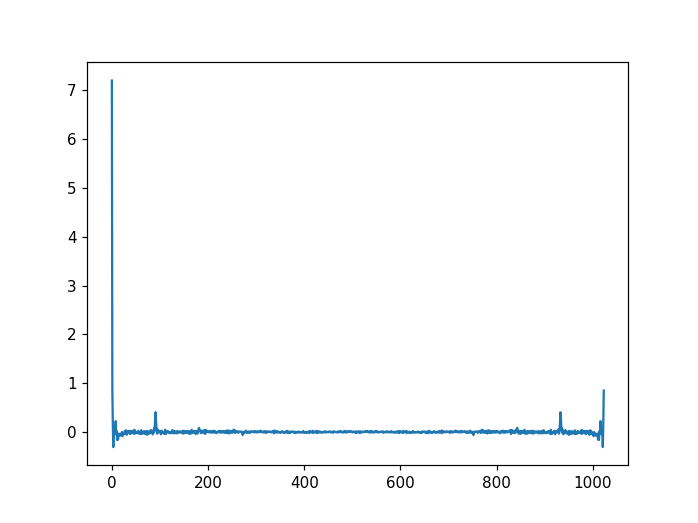

In [69]:
fig, axs = plt.subplots(1,1)

cepstrum_real = np.real(np.fft.ifft(np.log(np.abs(iy_fft_hamming))))
axs.plot(cepstrum_real)


(b) Use the cepstrum to compute the fundamental frequency $F_0$. Compare your results with those obtained in problem 1).

In [81]:
n_max = np.argmax(cepstrum_real[30:fft_n//2]) + 30
print(f"N_max: {n_max}")
f_0 = fs/n_max
print(f"Fundamental Frequency: {f_0}")

N_max: 91
Fundamental Frequency: 175.82417582417582


(c) In this subproblem you will use the cepstrum to estimate the spectral envelope
- Use liftering to extract the part of the ceptrum that represents the spectral envelope.
- Plot the spectral envelope as a function of frequency, and compare the result with the results from problem 1).

Hint 1: Remember that the cepstrum of a real signal is symmetric, so the liftered signal mus be symmetric as well.

Hint 2: The FFT of a real, symmtric signal is real, but due to round-off errors small imaginary noise may occur. Use `np.real` to get to the real part of the liftered log-spectrum.

<IPython.core.display.Javascript object>


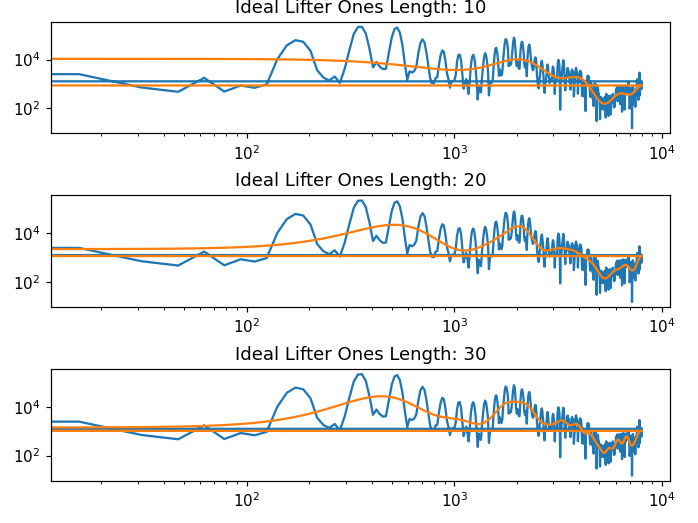

<IPython.core.display.Javascript object>


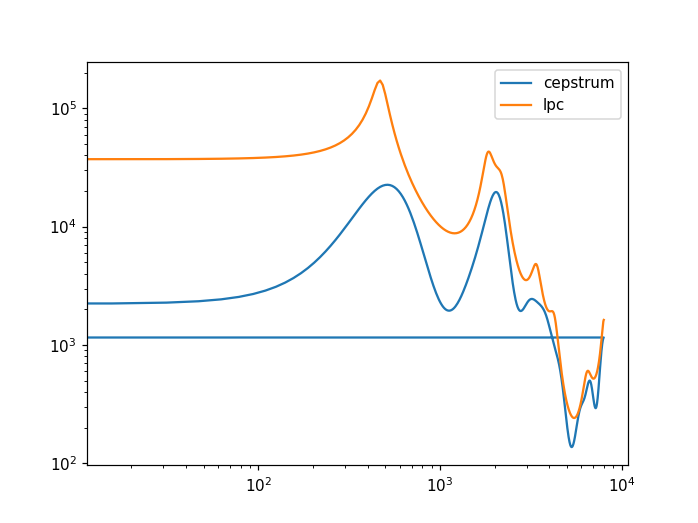

In [133]:
fig, axs = plt.subplots(3,1)
fig.tight_layout(h_pad=2)

spectral_envelopes = []

for index, ones_length in enumerate([10,20,30]):
    window_length_half = 512
    rect_window_half = np.concatenate(
        (np.ones(ones_length),np.zeros(window_length_half-ones_length))
    )
    rect_window_sym = np.concatenate((rect_window_half,rect_window_half[::-1]))
    cepstrum_liftered = cepstrum_real*rect_window_sym
    spectral_envelope = np.abs(np.exp(np.fft.fft(cepstrum_liftered,n=fft_n)))
    spectral_envelopes.append(spectral_envelope)
    axs[index].plot(iy_fft_freq,np.abs(iy_fft_hamming))
    axs[index].plot(iy_fft_freq,spectral_envelope)
    axs[index].set_xscale("log")
    axs[index].set_yscale("log")
    axs[index].set_title(f"Ideal Lifter Ones Length: {ones_length}")

fig, axs = plt.subplots(1,1)
axs.plot(iy_fft_freq,spectral_envelopes[1],label="cepstrum")
axs.plot(ws[2],np.abs(hs[2]),label="lpc")
axs.set_xscale("log")
axs.set_yscale("log")
axs.legend()